In [1]:
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.trainer import trainer
from score_models.models.mlp import MLPScoreModel
from score_models.train_steps.ncsn_train_steps import TrainStepNCSN
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import plot_gradient_field
from score_models.sampling import annealed_langevin_dynamics

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
L = 10
lr = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigma_min, sigma_max = 1.0, 20.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepNCSN(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=20000,
    log_every=1000,
    save_every=5000,
)

  5%|▌         | 1030/20000 [00:04<01:06, 283.54it/s]

Step 1000, Loss: 1.1472


 10%|█         | 2030/20000 [00:07<01:02, 289.83it/s]

Step 2000, Loss: 0.9453


 15%|█▌        | 3044/20000 [00:11<01:01, 277.17it/s]

Step 3000, Loss: 0.8510


 20%|██        | 4028/20000 [00:14<00:56, 284.86it/s]

Step 4000, Loss: 0.7609


 25%|██▌       | 5036/20000 [00:18<00:55, 270.86it/s]

Step 5000, Loss: 0.7690


 30%|███       | 6049/20000 [00:21<00:49, 283.12it/s]

Step 6000, Loss: 0.6777


 35%|███▌      | 7031/20000 [00:25<00:46, 280.75it/s]

Step 7000, Loss: 0.6886


 40%|████      | 8045/20000 [00:28<00:43, 273.55it/s]

Step 8000, Loss: 0.6458


 45%|████▌     | 9049/20000 [00:32<00:40, 272.48it/s]

Step 9000, Loss: 0.6340


 50%|█████     | 10029/20000 [00:36<00:35, 277.49it/s]

Step 10000, Loss: 0.5969


 55%|█████▌    | 11041/20000 [00:39<00:31, 282.42it/s]

Step 11000, Loss: 0.6221


 60%|██████    | 12057/20000 [00:43<00:28, 282.58it/s]

Step 12000, Loss: 0.5700


 65%|██████▌   | 13045/20000 [00:46<00:24, 281.87it/s]

Step 13000, Loss: 0.5516


 70%|███████   | 14053/20000 [00:50<00:21, 282.54it/s]

Step 14000, Loss: 0.5551


 75%|███████▌  | 15038/20000 [00:53<00:18, 270.99it/s]

Step 15000, Loss: 0.5779


 80%|████████  | 16031/20000 [00:57<00:14, 281.86it/s]

Step 16000, Loss: 0.5530


 85%|████████▌ | 17044/20000 [01:00<00:10, 279.96it/s]

Step 17000, Loss: 0.6262


 90%|█████████ | 18052/20000 [01:04<00:06, 304.42it/s]

Step 18000, Loss: 0.5694


 95%|█████████▌| 19057/20000 [01:07<00:03, 313.16it/s]

Step 19000, Loss: 0.5396


100%|██████████| 20000/20000 [01:10<00:00, 282.90it/s]

Step 20000, Loss: 0.5411


In [5]:
# sample some datapoints
samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(500, 2), 
    sigmas=sigmas, 
    r=(-8, 8), 
    T=100,
    eps=0.1,
).cpu().numpy()

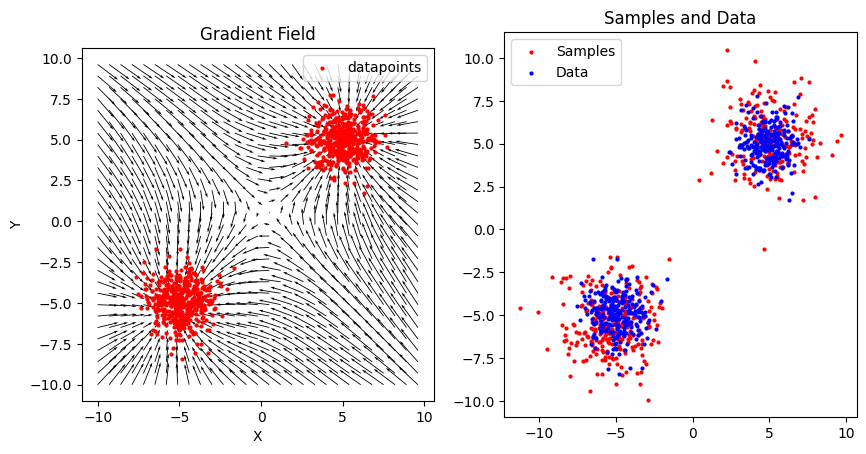

In [6]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot gradient field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000], ax=ax[0])

# plot original data and samples
ax[1].scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax[1].scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax[1].set_title('Samples and Data')
plt.legend();